## Demo notebook for accessing NLCD data on Azure

This notebook provides an example of accessing NLCD (National Land Cover Database) data from blob storage on Azure, including (1) looking at the directory where data is stored, (2) load the cloud optimized geotiff for a particular year, and (3) doing some simple processing and plotting of the data.

NLCD data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on NLCD data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using NLCD data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports and constants

In [1]:
import fsspec
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr

account_name = 'cpdataeuwest'
container = 'cpdata'
year = 2001
area = 'conus' # 'conus' or 'ak' (for Alaska)

### View all the available nationwide land cover products

In [2]:
fs = fsspec.get_filesystem_class('az')(account_name=account_name)
fs.ls(path=f'{container}/raw/nlcd/{area}/30m/')

['cpdata/raw/nlcd/conus/30m/2001.tif',
 'cpdata/raw/nlcd/conus/30m/2004.tif',
 'cpdata/raw/nlcd/conus/30m/2006.tif',
 'cpdata/raw/nlcd/conus/30m/2008.tif',
 'cpdata/raw/nlcd/conus/30m/2011.tif',
 'cpdata/raw/nlcd/conus/30m/2013.tif',
 'cpdata/raw/nlcd/conus/30m/2016.tif',
 'cpdata/raw/nlcd/conus/30m/change.tif']

### Load data for a single year

In [3]:
da = xr.open_rasterio(f'https://{account_name}.blob.core.windows.net/' + \
                      f'{container}/raw/nlcd/{area}/30m/{year}.tif', 
                      chunks=dict(x=2560, y=2560))

# Transform our data array to dataset by selecting the only data variable ('band'), and
# rename it to something useful ('landcover')
ds = da.to_dataset(dim='band').rename({1: 'landcover'})
ds

<xarray.Dataset>
Dimensions:    (x: 161190, y: 104424)
Coordinates:
  * y          (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
  * x          (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
Data variables:
    landcover  (y, x) uint8 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    transform:           (30.0, 0.0, -2493045.0, 0.0, -30.0, 3310005.0)
    crs:                 +proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45...
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('Layer_1',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

### Plot forest cover data

In [4]:
# Let's look at forest lands in the U.S. 
#
# Land cover data are stored as categorical variables, and the legend for the code
# can be found in: 
#
# https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend
#
# Forest lands correspond to codes 41, 42, and 43.

deciduous = ds.landcover.isin([41]).astype(int)
evergreen = ds.landcover.isin([42]).astype(int)
mixed     = ds.landcover.isin([43]).astype(int)

# Coarsen by 100x on each dimension to get to a reasonable plotting size 
factor = 100
deciduous = deciduous.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
evergreen = evergreen.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
mixed = mixed.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()

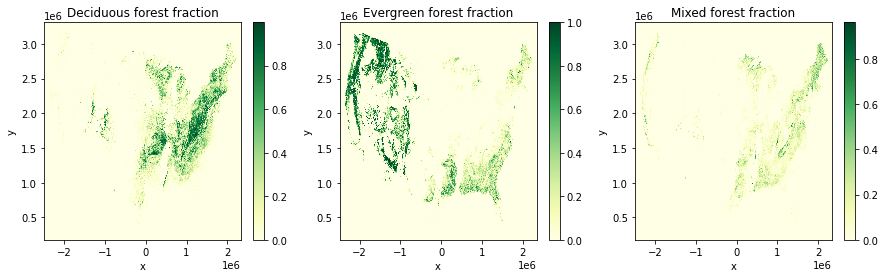

In [5]:
# Now let's plot the different forests and see their distributions in the continental US 
plt.figure(figsize=(15,4))

ax = plt.subplot(1, 3, 1)
deciduous.plot(cmap='YlGn')
plt.title('Deciduous forest fraction')

plt.subplot(1, 3, 2)
evergreen.plot(cmap='YlGn')
plt.title('Evergreen forest fraction')

plt.subplot(1, 3, 3)
mixed.plot(cmap='YlGn')
plt.title('Mixed forest fraction')

plt.show()
plt.close()